In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "7b"
target_lang = "ru"
input_lang = "en"
type = "tuned-chinese-en"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for ru 15 of 115 are single tokens
final length of df_en_ru_en: 114


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
df_en_target_input

,lang_ru,en,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru,lang_en,en_in,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,ru,book,книга,"A ""book"" is used to read stories. Answer: ""book"".","""Книга"" используется для чтения историй. Ответ...","""___"" используется для чтения историй. Ответ: ...",no error,en,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error
1,ru,cloud,облако,"A ""cloud"" is a visible mass of condensed water...",Облако - это видимая масса конденсированного в...,"""___"" - это видимая масса конденсированного во...",no error,en,cloud,"A ""cloud"" is a visible mass of condensed water...","A ""cloud"" is a visible mass of condensed water...","A ""___"" is a visible mass of condensed water v...",no error
2,ru,bag,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
3,ru,mouth,рот,"A ""mouth"" is used to eat food and speak. Answe...",Рот используется для приема пищи и речи. Ответ...,"""___"" используется для приема пищи и речи. Отв...",no error,en,mouth,"A ""mouth"" is used to eat food and speak. Answe...","A ""mouth"" is used to eat food and speak. Answe...","A ""___"" is used to eat food and speak. Answer:...",no error
4,ru,soil,почва,"""A ""soil"" is used for planting trees and crops...","""Почва"" используется для посадки деревьев и вы...","""___"" используется для посадки деревьев и выра...",no error,en,soil,"""A ""soil"" is used for planting trees and crops...","""A ""soil"" is used for planting trees and crops...","""A ""___"" is used for planting trees and crops....",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ru,hundred,сотня,"A ""hundred"" is a numerical value equal to 10 t...","Сотня - это числовое значение, равное 10 десят...","""___"" - это числовое значение, равное 10 десят...",no error,en,hundred,"A ""hundred"" is a numerical value equal to 10 t...","A ""hundred"" is a numerical value equal to 10 t...","A ""___"" is a numerical value equal to 10 tens....",no error
110,ru,office,офис,"An ""office"" is a place where people usually do...","Офис - это место, где люди обычно выполняют св...","""___"" - это место, где люди обычно выполняют с...",no error,en,office,"An ""office"" is a place where people usually do...","An ""office"" is a place where people usually do...","An ""___"" is a place where people usually do th...",no error
111,ru,sound,звук,"A ""sound"" is something we hear. Answer: ""sound"".","Звук - это то, что мы слышим. Ответ: ""звук"".","""___"" - это то, что мы слышим. Ответ: ""звук"".",no error,en,sound,"A ""sound"" is something we hear. Answer: ""sound"".","A ""sound"" is something we hear. Answer: ""sound"".","A ""___"" is something we hear. Answer: ""sound"".",no error
112,ru,power,власть,"""A ""power"" is used to control or influence peo...","""Власть"" используется для контроля или влияния...","""___"" используется для контроля или влияния на...",no error,en,power,"""A ""power"" is used to control or influence peo...","""A ""power"" is used to control or influence peo...","""A ""___"" is used to control or influence peopl...",no error


In [12]:
chinese

,lang,word_original,word_translation,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked
0,zh,book,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
1,zh,cloud,云,"A ""cloud"" is a visible mass of condensed water...","""云""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。","""_""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。"
2,zh,bag,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,zh,mouth,口,"A ""mouth"" is used to eat food and speak. Answe...","""口""用来吃食物和说话。答案：""口""。","""_""用来吃食物和说话。答案：""口""。"
4,zh,soil,土,"""A ""soil"" is used for planting trees and crops...","""土""用于种植树木和作物。答案：""土""。","""_""用于种植树木和作物。答案：""土""。"
...,...,...,...,...,...,...
134,zh,rise,起,"""A ""rise"" is used to describe an increase or u...","""起""用来描述增加或向上移动。答案：""起""。","""_""用来描述增加或向上移动。答案：""起""。"
135,zh,left,左,"'A ""left"" is a direction opposite to right. An...","""左""是右的相反方向。答案：""左""。","""_""是右的相反方向。答案：""左""。"
136,zh,sound,音,"A ""sound"" is something we hear. Answer: ""sound"".","""音""是我们听到的东西。答案：""音""。","""_""是我们听到的东西。答案：""音""。"
137,zh,power,力,"""A ""power"" is used to control or influence peo...","""力""用来控制或影响人或物。答案：""力""。","""_""用来控制或影响人或物。答案：""力""。"


In [13]:
df_en_target_input

,lang_ru,en,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru,lang_en,en_in,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,ru,book,книга,"A ""book"" is used to read stories. Answer: ""book"".","""Книга"" используется для чтения историй. Ответ...","""___"" используется для чтения историй. Ответ: ...",no error,en,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error
1,ru,cloud,облако,"A ""cloud"" is a visible mass of condensed water...",Облако - это видимая масса конденсированного в...,"""___"" - это видимая масса конденсированного во...",no error,en,cloud,"A ""cloud"" is a visible mass of condensed water...","A ""cloud"" is a visible mass of condensed water...","A ""___"" is a visible mass of condensed water v...",no error
2,ru,bag,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
3,ru,mouth,рот,"A ""mouth"" is used to eat food and speak. Answe...",Рот используется для приема пищи и речи. Ответ...,"""___"" используется для приема пищи и речи. Отв...",no error,en,mouth,"A ""mouth"" is used to eat food and speak. Answe...","A ""mouth"" is used to eat food and speak. Answe...","A ""___"" is used to eat food and speak. Answer:...",no error
4,ru,soil,почва,"""A ""soil"" is used for planting trees and crops...","""Почва"" используется для посадки деревьев и вы...","""___"" используется для посадки деревьев и выра...",no error,en,soil,"""A ""soil"" is used for planting trees and crops...","""A ""soil"" is used for planting trees and crops...","""A ""___"" is used for planting trees and crops....",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ru,hundred,сотня,"A ""hundred"" is a numerical value equal to 10 t...","Сотня - это числовое значение, равное 10 десят...","""___"" - это числовое значение, равное 10 десят...",no error,en,hundred,"A ""hundred"" is a numerical value equal to 10 t...","A ""hundred"" is a numerical value equal to 10 t...","A ""___"" is a numerical value equal to 10 tens....",no error
110,ru,office,офис,"An ""office"" is a place where people usually do...","Офис - это место, где люди обычно выполняют св...","""___"" - это место, где люди обычно выполняют с...",no error,en,office,"An ""office"" is a place where people usually do...","An ""office"" is a place where people usually do...","An ""___"" is a place where people usually do th...",no error
111,ru,sound,звук,"A ""sound"" is something we hear. Answer: ""sound"".","Звук - это то, что мы слышим. Ответ: ""звук"".","""___"" - это то, что мы слышим. Ответ: ""звук"".",no error,en,sound,"A ""sound"" is something we hear. Answer: ""sound"".","A ""sound"" is something we hear. Answer: ""sound"".","A ""___"" is something we hear. Answer: ""sound"".",no error
112,ru,power,власть,"""A ""power"" is used to control or influence peo...","""Власть"" используется для контроля или влияния...","""___"" используется для контроля или влияния на...",no error,en,power,"""A ""power"" is used to control or influence peo...","""A ""power"" is used to control or influence peo...","""A ""___"" is used to control or influence peopl...",no error


In [14]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/114 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                             | 1/114 [00:00<00:20,  5.42it/s]

  2%|███▋                                                                                                                                                                                                           | 2/114 [00:00<00:23,  4.67it/s]

  3%|█████▍                                                                                                                                                                                                         | 3/114 [00:00<00:21,  5.13it/s]

  4%|███████▎                                                                                                                                                                                                       | 4/114 [00:00<00:20,  5.30it/s]

  4%|█████████                                                                                                                                                                                                      | 5/114 [00:00<00:20,  5.34it/s]

  5%|██████████▉                                                                                                                                                                                                    | 6/114 [00:01<00:22,  4.83it/s]

  6%|████████████▋                                                                                                                                                                                                  | 7/114 [00:01<00:22,  4.69it/s]

  7%|██████████████▌                                                                                                                                                                                                | 8/114 [00:01<00:21,  4.84it/s]

  8%|████████████████▎                                                                                                                                                                                              | 9/114 [00:01<00:21,  4.87it/s]

  9%|██████████████████                                                                                                                                                                                            | 10/114 [00:02<00:22,  4.59it/s]

 10%|███████████████████▉                                                                                                                                                                                          | 11/114 [00:02<00:20,  5.00it/s]

 11%|█████████████████████▋                                                                                                                                                                                        | 12/114 [00:02<00:23,  4.36it/s]

 11%|███████████████████████▍                                                                                                                                                                                      | 13/114 [00:02<00:22,  4.54it/s]

 12%|█████████████████████████▎                                                                                                                                                                                    | 14/114 [00:02<00:20,  4.77it/s]

 13%|███████████████████████████                                                                                                                                                                                   | 15/114 [00:03<00:19,  4.95it/s]

 14%|████████████████████████████▉                                                                                                                                                                                 | 16/114 [00:03<00:20,  4.87it/s]

 15%|██████████████████████████████▋                                                                                                                                                                               | 17/114 [00:03<00:19,  4.92it/s]

 16%|████████████████████████████████▌                                                                                                                                                                             | 18/114 [00:03<00:18,  5.10it/s]

 17%|██████████████████████████████████▎                                                                                                                                                                           | 19/114 [00:03<00:18,  5.08it/s]

 18%|████████████████████████████████████▏                                                                                                                                                                         | 20/114 [00:04<00:18,  5.01it/s]

 18%|█████████████████████████████████████▉                                                                                                                                                                        | 21/114 [00:04<00:17,  5.21it/s]

 19%|███████████████████████████████████████▊                                                                                                                                                                      | 22/114 [00:04<00:17,  5.24it/s]

 20%|█████████████████████████████████████████▌                                                                                                                                                                    | 23/114 [00:04<00:17,  5.17it/s]

 21%|███████████████████████████████████████████▎                                                                                                                                                                  | 24/114 [00:04<00:17,  5.15it/s]

 22%|█████████████████████████████████████████████▏                                                                                                                                                                | 25/114 [00:05<00:16,  5.39it/s]

 23%|██████████████████████████████████████████████▉                                                                                                                                                               | 26/114 [00:05<00:16,  5.40it/s]

 24%|████████████████████████████████████████████████▊                                                                                                                                                             | 27/114 [00:05<00:18,  4.80it/s]

 25%|██████████████████████████████████████████████████▌                                                                                                                                                           | 28/114 [00:05<00:18,  4.77it/s]

 25%|████████████████████████████████████████████████████▍                                                                                                                                                         | 29/114 [00:05<00:17,  4.78it/s]

 26%|██████████████████████████████████████████████████████▏                                                                                                                                                       | 30/114 [00:06<00:19,  4.38it/s]

 27%|████████████████████████████████████████████████████████                                                                                                                                                      | 31/114 [00:06<00:17,  4.68it/s]

 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                    | 32/114 [00:06<00:19,  4.27it/s]

 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                  | 33/114 [00:06<00:17,  4.59it/s]

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                                | 34/114 [00:06<00:16,  4.71it/s]

 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                              | 35/114 [00:07<00:16,  4.80it/s]

 32%|█████████████████████████████████████████████████████████████████                                                                                                                                             | 36/114 [00:07<00:15,  5.06it/s]

 32%|██████████████████████████████████████████████████████████████████▊                                                                                                                                           | 37/114 [00:07<00:15,  4.85it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 38/114 [00:07<00:14,  5.29it/s]

 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 39/114 [00:07<00:14,  5.26it/s]

 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 40/114 [00:08<00:14,  5.14it/s]

 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                    | 41/114 [00:08<00:13,  5.27it/s]

 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 42/114 [00:08<00:12,  5.58it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 43/114 [00:08<00:13,  5.26it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 44/114 [00:08<00:12,  5.68it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 45/114 [00:09<00:12,  5.58it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 46/114 [00:09<00:12,  5.30it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 47/114 [00:09<00:12,  5.50it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 48/114 [00:09<00:11,  5.58it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 49/114 [00:09<00:11,  5.53it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 50/114 [00:09<00:12,  5.22it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 51/114 [00:10<00:12,  5.18it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 52/114 [00:10<00:11,  5.21it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 53/114 [00:10<00:12,  5.08it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 54/114 [00:10<00:12,  4.95it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 55/114 [00:11<00:12,  4.61it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 56/114 [00:11<00:12,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 57/114 [00:11<00:12,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 58/114 [00:11<00:12,  4.61it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 59/114 [00:11<00:11,  4.62it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 60/114 [00:12<00:11,  4.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 61/114 [00:12<00:11,  4.81it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 62/114 [00:12<00:10,  4.80it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 63/114 [00:12<00:11,  4.52it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 64/114 [00:12<00:10,  4.60it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 65/114 [00:13<00:11,  4.39it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 66/114 [00:13<00:11,  4.06it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 67/114 [00:13<00:12,  3.69it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 68/114 [00:14<00:12,  3.82it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 69/114 [00:14<00:11,  3.75it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 70/114 [00:14<00:11,  3.97it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 71/114 [00:14<00:10,  4.27it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 72/114 [00:14<00:09,  4.56it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 73/114 [00:15<00:08,  4.66it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 74/114 [00:15<00:08,  4.58it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 75/114 [00:15<00:10,  3.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 76/114 [00:15<00:09,  4.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 77/114 [00:16<00:09,  4.08it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 78/114 [00:16<00:08,  4.44it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79/114 [00:16<00:07,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 80/114 [00:16<00:07,  4.44it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 81/114 [00:17<00:07,  4.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 82/114 [00:17<00:07,  4.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 83/114 [00:17<00:07,  4.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 84/114 [00:17<00:06,  4.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 85/114 [00:18<00:07,  3.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 86/114 [00:18<00:06,  4.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 87/114 [00:18<00:05,  4.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 88/114 [00:18<00:06,  4.25it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 89/114 [00:18<00:06,  3.98it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 90/114 [00:19<00:06,  3.98it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 91/114 [00:19<00:05,  4.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 92/114 [00:19<00:05,  3.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 93/114 [00:19<00:04,  4.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 94/114 [00:20<00:05,  3.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 95/114 [00:20<00:04,  4.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 96/114 [00:20<00:04,  4.27it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 97/114 [00:20<00:04,  4.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 98/114 [00:21<00:03,  4.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 99/114 [00:21<00:03,  4.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 100/114 [00:21<00:03,  4.07it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 101/114 [00:21<00:03,  3.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 102/114 [00:22<00:02,  4.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 103/114 [00:22<00:02,  4.36it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 104/114 [00:22<00:02,  4.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 105/114 [00:22<00:02,  4.29it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 106/114 [00:23<00:01,  4.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 107/114 [00:23<00:01,  4.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 108/114 [00:23<00:01,  4.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 109/114 [00:23<00:01,  4.24it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 110/114 [00:23<00:00,  4.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 111/114 [00:24<00:00,  4.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 112/114 [00:24<00:00,  4.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 113/114 [00:24<00:00,  4.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:24<00:00,  4.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:24<00:00,  4.60it/s]

In [15]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [16]:
df["prompt"][0]

'English: "group" - Русский: "группа"\nEnglish: "mountain" - Русский: "гора"\nEnglish: "snow" - Русский: "снег"\nEnglish: "color" - Русский: "цвет"\nEnglish: "book" - Русский: "'

In [17]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [18]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.20it/s]

2it [00:00,  2.34it/s]

3it [00:01,  3.38it/s]

4it [00:01,  4.08it/s]

5it [00:01,  4.82it/s]

6it [00:01,  5.32it/s]

7it [00:01,  5.87it/s]

8it [00:01,  6.24it/s]

9it [00:01,  6.61it/s]

10it [00:02,  6.87it/s]

11it [00:02,  6.93it/s]

12it [00:02,  6.99it/s]

13it [00:02,  7.07it/s]

14it [00:02,  6.91it/s]

15it [00:02,  6.65it/s]

16it [00:03,  6.47it/s]

17it [00:03,  5.96it/s]

18it [00:03,  6.28it/s]

19it [00:03,  6.19it/s]

20it [00:03,  6.40it/s]

21it [00:03,  6.69it/s]

22it [00:03,  6.84it/s]

23it [00:04,  6.94it/s]

24it [00:04,  7.02it/s]

25it [00:04,  7.08it/s]

26it [00:04,  7.07it/s]

27it [00:04,  7.13it/s]

28it [00:04,  6.81it/s]

29it [00:04,  6.77it/s]

30it [00:05,  6.58it/s]

31it [00:05,  6.60it/s]

32it [00:05,  6.52it/s]

33it [00:05,  6.43it/s]

34it [00:05,  6.56it/s]

35it [00:05,  6.24it/s]

36it [00:06,  6.23it/s]

37it [00:06,  6.42it/s]

38it [00:06,  6.61it/s]

39it [00:06,  6.75it/s]

40it [00:06,  6.66it/s]

41it [00:06,  6.78it/s]

42it [00:06,  6.74it/s]

43it [00:07,  6.79it/s]

44it [00:07,  6.77it/s]

45it [00:07,  6.74it/s]

46it [00:07,  6.80it/s]

47it [00:07,  6.74it/s]

48it [00:07,  6.77it/s]

49it [00:07,  6.75it/s]

50it [00:08,  6.74it/s]

51it [00:08,  6.75it/s]

52it [00:08,  6.70it/s]

53it [00:08,  6.74it/s]

54it [00:08,  6.66it/s]

55it [00:08,  6.66it/s]

56it [00:09,  6.71it/s]

57it [00:09,  6.63it/s]

58it [00:09,  6.07it/s]

59it [00:09,  6.17it/s]

60it [00:09,  6.38it/s]

61it [00:09,  6.53it/s]

62it [00:09,  6.62it/s]

63it [00:10,  6.60it/s]

64it [00:10,  6.69it/s]

65it [00:10,  6.73it/s]

66it [00:10,  6.78it/s]

67it [00:10,  6.82it/s]

68it [00:10,  6.86it/s]

69it [00:10,  6.89it/s]

70it [00:11,  6.90it/s]

71it [00:11,  7.00it/s]

72it [00:11,  7.08it/s]

73it [00:11,  7.11it/s]

74it [00:11,  7.08it/s]

75it [00:11,  7.07it/s]

76it [00:11,  7.13it/s]

77it [00:12,  7.05it/s]

78it [00:12,  7.10it/s]

79it [00:12,  7.09it/s]

80it [00:12,  7.14it/s]

81it [00:12,  7.07it/s]

82it [00:12,  7.05it/s]

83it [00:12,  6.46it/s]

84it [00:13,  6.68it/s]

85it [00:13,  6.82it/s]

86it [00:13,  6.94it/s]

87it [00:13,  7.02it/s]

88it [00:13,  7.09it/s]

89it [00:13,  7.13it/s]

90it [00:13,  7.15it/s]

91it [00:14,  7.14it/s]

92it [00:14,  7.16it/s]

93it [00:14,  7.14it/s]

94it [00:14,  7.17it/s]

95it [00:14,  7.17it/s]

96it [00:14,  7.22it/s]

97it [00:14,  7.21it/s]

98it [00:15,  7.23it/s]

99it [00:15,  6.89it/s]

100it [00:15,  6.98it/s]

101it [00:15,  7.05it/s]

102it [00:15,  7.17it/s]

103it [00:15,  7.25it/s]

104it [00:15,  7.33it/s]

105it [00:16,  7.42it/s]

106it [00:16,  7.08it/s]

107it [00:16,  6.79it/s]

108it [00:16,  6.77it/s]

109it [00:16,  6.72it/s]

110it [00:16,  6.63it/s]

111it [00:16,  6.70it/s]

112it [00:17,  6.69it/s]

113it [00:17,  6.74it/s]

114it [00:17,  6.74it/s]

114it [00:17,  6.55it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


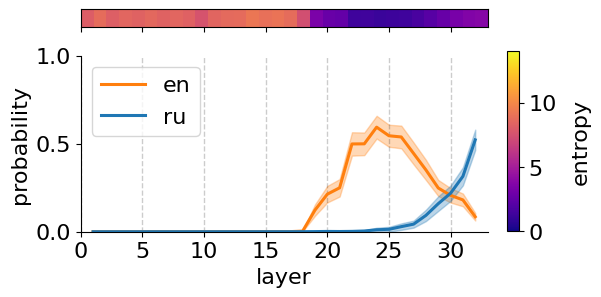

In [19]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

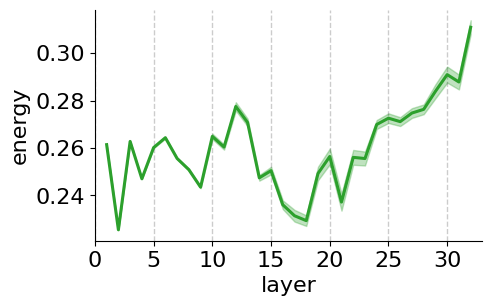

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')